In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from uncertainties import ufloat
from ctypes import c_double

import ROOT
import math
ROOT.EnableImplicitMT()    # Tells ROOT to go parallel

/groups/hephy/cms/alikaan.gueven/conda/envs/SDV/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Welcome to JupyROOT 6.28/00


In [2]:
import os

unique_dir = "SDVSecVtx_ParTScore"

# ------------------------------------------------
sig_tag  = 'stop_M600_585_ct20_2018'




histname = "MET_pt_corr_vs_Max_ML_score"
tdir     = "all_evt"




bkg_dir = "/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/" + unique_dir + "/bkg"
sig_dir = "/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/" + unique_dir + "/sig"



sig_file = ROOT.TFile(os.path.join(sig_dir, f"{sig_tag}_hist.root"))
sig_dir  = getattr(sig_file, tdir)
sig_hist = getattr(sig_dir, histname).Clone()


bkg_file = ROOT.TFile(os.path.join(bkg_dir, f"all_2018_hist.root"))
bkg_dir  = getattr(bkg_file, tdir)
bkg_hist = getattr(bkg_dir, histname).Clone()

In [3]:
x_binwidth = sig_hist.GetXaxis().GetBinWidth(1)
y_binwidth = sig_hist.GetYaxis().GetBinWidth(1)

In [4]:
xax = sig_hist.GetXaxis()
yax = sig_hist.GetYaxis()

x_min = xax.GetBinLowEdge(1)
x_max = xax.GetBinUpEdge(xax.GetLast())

y_min = yax.GetBinLowEdge(1)
y_max = yax.GetBinUpEdge(yax.GetLast())

print(x_min, x_max, x_binwidth)
print(y_min, y_max, y_binwidth)

0.0 1000.0 50.0
0.0 1.0 0.002


In [5]:
MET_boundaryList     = np.arange(200   + x_binwidth, x_max, x_binwidth)
MLScore_boundaryList = np.arange(y_min + y_binwidth, y_max, y_binwidth)

In [7]:
MET_step = MET_boundaryList[1] - MET_boundaryList[0]
MLScore_step = MLScore_boundaryList[1] - MLScore_boundaryList[0]

# print(MET_boundaryList)
# print(MLScore_boundaryList)

MLScore_min = bkg_hist.GetYaxis().FindBin(0.50)

In [28]:
import numpy as np
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=FutureWarning)

def makeTables(
        xedges: np.ndarray,
        yedges: np.ndarray,
        bkg_hist: ROOT.TH2,
        sig_hist: ROOT.TH2,
        x_loCut: float = 0.0,
        y_loCut: float = 0.0,
        sigScale: float = 1.0,
        bkgScale: float = 1.0,
):
    x_step = xedges[1] - xedges[0]
    y_step = yedges[1] - yedges[0]
    empty_df = pd.DataFrame(index=np.arange(xedges[0], xedges[-1]+x_step, x_step),
                            columns=np.arange(yedges[0], yedges[-1]+y_step, y_step),
                            dtype= float)

    # Create empty tables
    tableNames = ['sig_NA', 'sig_NB', 'sig_NC', 'sig_ND',
                  'bkg_NA', 'bkg_NB', 'bkg_NC', 'bkg_ND',
                  'sig_NA_unc', 'sig_NB_unc', 'sig_NC_unc', 'sig_ND_unc',
                  'bkg_NA_unc', 'bkg_NB_unc', 'bkg_NC_unc', 'bkg_ND_unc',
                  'Z_NA', 'Z_NB', 'Z_NC', 'Z_ND',
                  'noncl', 'noncl_unc',
                ]
    tables = dict()
    for name in tableNames:
        tables[name] = empty_df.copy()
     
    for x_boundary in xedges:
        for y_boundary in yedges:
            x_lo    = bkg_hist.GetXaxis().FindBin(x_loCut)
            x_up    = bkg_hist.GetNbinsX()+1
            x_bound = bkg_hist.GetXaxis().FindBin(x_boundary)

            y_lo    = bkg_hist.GetYaxis().FindBin(y_loCut)
            y_up    = bkg_hist.GetNbinsY()+1
            y_bound = bkg_hist.GetYaxis().FindBin(y_boundary)


            # ------------ Backgrounds --------------
            c_err = c_double(0.0)
            NA = ufloat(bkg_hist.IntegralAndError(x_bound,    x_up,       y_bound,    y_up,          c_err), c_err.value) * bkgScale
            NB = ufloat(bkg_hist.IntegralAndError(x_lo,       x_bound-1,  y_bound,    y_up,          c_err), c_err.value) * bkgScale
            NC = ufloat(bkg_hist.IntegralAndError(x_bound,    x_up,       y_lo,      y_bound-1,      c_err), c_err.value) * bkgScale
            ND = ufloat(bkg_hist.IntegralAndError(x_lo,       x_bound-1,  y_lo,      y_bound-1,      c_err), c_err.value) * bkgScale

            num   = NB * NC
            denom = NA * ND
            noncl = np.abs(1- num/denom) if ND.n > 0 else ufloat(0.0, 0.0)

            eps = 5e-1

            tables['bkg_NA'].loc[x_boundary, y_boundary] = max(eps, NA.n) # max: in case there are negative bins
            tables['bkg_NB'].loc[x_boundary, y_boundary] = max(eps, NB.n)
            tables['bkg_NC'].loc[x_boundary, y_boundary] = max(eps, NC.n)
            tables['bkg_ND'].loc[x_boundary, y_boundary] = max(eps, ND.n)

            tables['bkg_NA_unc'].loc[x_boundary, y_boundary] = max(eps, NA.s)
            tables['bkg_NB_unc'].loc[x_boundary, y_boundary] = max(eps, NB.s)
            tables['bkg_NC_unc'].loc[x_boundary, y_boundary] = max(eps, NC.s)
            tables['bkg_ND_unc'].loc[x_boundary, y_boundary] = max(eps, ND.s)

            tables['noncl'].loc[x_boundary, y_boundary]     = noncl.n
            tables['noncl_unc'].loc[x_boundary, y_boundary] = noncl.s
            

            # ------------ Signals --------------
            c_err = c_double(0.0)
            NA = ufloat(sig_hist.IntegralAndError(x_bound,    x_up,       y_bound,    y_up,          c_err), c_err.value) * sigScale
            NB = ufloat(sig_hist.IntegralAndError(x_lo,       x_bound-1,  y_bound,    y_up,          c_err), c_err.value) * sigScale
            NC = ufloat(sig_hist.IntegralAndError(x_bound,    x_up,       y_lo,      y_bound-1,      c_err), c_err.value) * sigScale
            ND = ufloat(sig_hist.IntegralAndError(x_lo,       x_bound-1,  y_lo,      y_bound-1,      c_err), c_err.value) * sigScale

            eps = 5e-1

            tables['sig_NA'].loc[x_boundary, y_boundary] = max(eps, NA.n) # max: in case there are negative bins
            tables['sig_NB'].loc[x_boundary, y_boundary] = max(eps, NB.n)
            tables['sig_NC'].loc[x_boundary, y_boundary] = max(eps, NC.n)
            tables['sig_ND'].loc[x_boundary, y_boundary] = max(eps, ND.n)

            tables['sig_NA_unc'].loc[x_boundary, y_boundary] = max(eps, NA.s)
            tables['sig_NB_unc'].loc[x_boundary, y_boundary] = max(eps, NB.s)
            tables['sig_NC_unc'].loc[x_boundary, y_boundary] = max(eps, NC.s)
            tables['sig_ND_unc'].loc[x_boundary, y_boundary] = max(eps, ND.s)

            # ------------ Significance --------------

            Z_NA      = ROOT.RooStats.AsimovSignificance(tables['sig_NA'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NA'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NA_unc'].loc[x_boundary, y_boundary])
            Z_NB      = ROOT.RooStats.AsimovSignificance(tables['sig_NB'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NB'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NB_unc'].loc[x_boundary, y_boundary])
            Z_NC      = ROOT.RooStats.AsimovSignificance(tables['sig_NC'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NC'].loc[x_boundary, y_boundary],
                                                         tables['bkg_NC_unc'].loc[x_boundary, y_boundary])
            Z_ND      = ROOT.RooStats.AsimovSignificance(tables['sig_ND'].loc[x_boundary, y_boundary],
                                                         tables['bkg_ND'].loc[x_boundary, y_boundary],
                                                         tables['bkg_ND_unc'].loc[x_boundary, y_boundary])

            
            tables['Z_NA'].loc[x_boundary, y_boundary] = Z_NA
            tables['Z_NB'].loc[x_boundary, y_boundary] = Z_NB
            tables['Z_NC'].loc[x_boundary, y_boundary] = Z_NC
            tables['Z_ND'].loc[x_boundary, y_boundary] = Z_ND
            
    return tables

In [30]:
tables = makeTables(
    MET_boundaryList,
    MLScore_boundaryList[::4],
    bkg_hist,
    sig_hist,
    x_loCut = x_min,
    y_loCut = y_min,
    sigScale = 1.0,
    bkgScale = 1.0,
)

In [31]:
noncl = tables['noncl']
noncl_plus1s = tables['noncl'] + tables['noncl_unc']

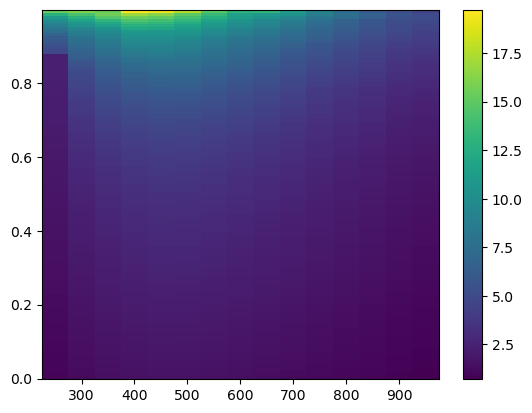

In [38]:
import matplotlib.pyplot as plt
Z = tables['Z_NA']

pcm = plt.pcolormesh(Z.index, Z.columns, Z.T, cmap='viridis')
cbar = plt.colorbar(pcm)
levels = [0.05, 0.10, 0.20]
levels = [lv for lv in levels if lv <= np.nanmax(Z.values)]
if levels:
    cont = plt.contour(Z.index, Z.columns, Z.T, levels=levels, colors="white", linewidths=1.0)
    plt.clabel(cont, fontsize="smaller")
# plt.ylim(0.9, 1.0)
plt.show()

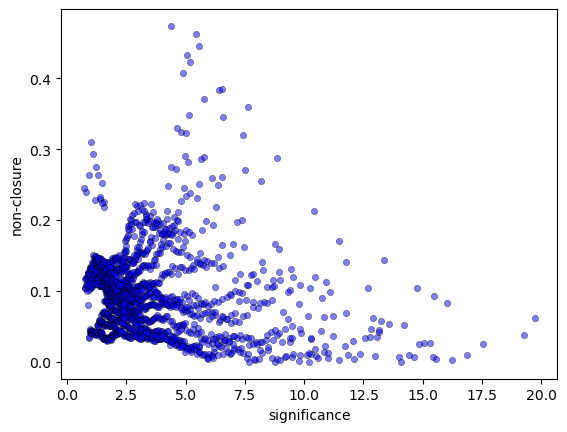

In [51]:
import matplotlib.pyplot as plt
for col in Z.columns:
    plt.scatter(Z[col], noncl[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
plt.xlabel('significance')
plt.ylabel('non-closure')
plt.show()

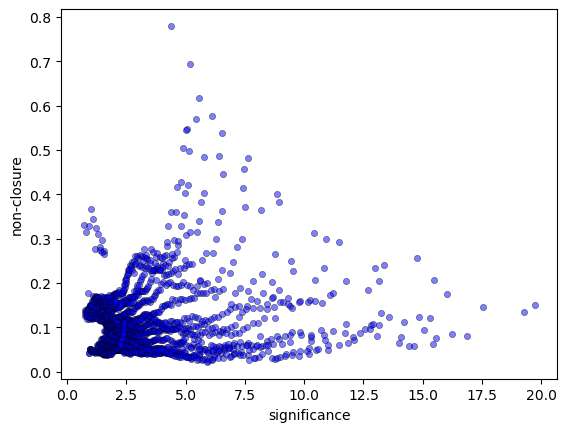

In [52]:
noncl_plus1s
import matplotlib.pyplot as plt
for col in Z.columns:
    plt.scatter(Z[col], noncl_plus1s[col], color="blue", alpha=0.5, s=20, edgecolors="k", linewidths=0.5)
plt.xlabel('significance')
plt.ylabel('non-closure')
plt.show()

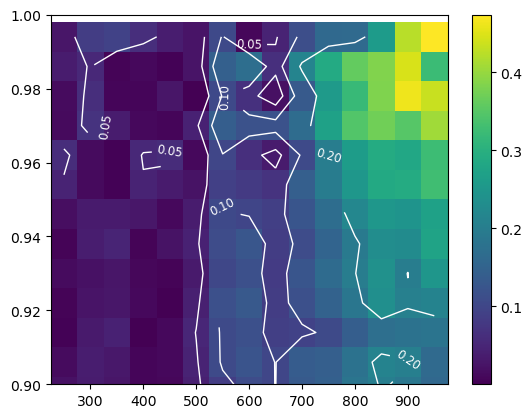

In [ ]:
import matplotlib.pyplot as plt
noncl = tables['noncl']

pcm = plt.pcolormesh(noncl.index, noncl.columns, noncl.T, cmap='viridis')
cbar = plt.colorbar(pcm)
# plt.clim(0, 0.50)
levels = [0.05, 0.10, 0.20]
levels = [lv for lv in levels if lv <= np.nanmax(noncl.values)]
if levels:
    cont = plt.contour(noncl.index, noncl.columns, noncl.T, levels=levels, colors="white", linewidths=1.0)
    plt.clabel(cont, fontsize="smaller")
plt.ylim(0.9, 1.0)
plt.show()

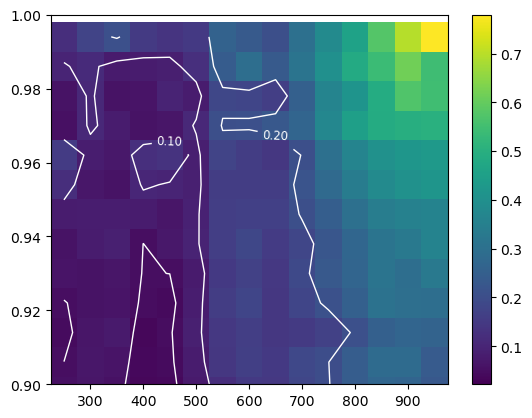

In [136]:
import matplotlib.pyplot as plt
noncl = tables['noncl'] + tables['noncl_unc']
pcm = plt.pcolormesh(noncl.index, noncl.columns, noncl.T, cmap='viridis')
cbar = plt.colorbar(pcm)
# plt.clim(0, 0.50)
levels = [0.05, 0.10, 0.20]
levels = [lv for lv in levels if lv <= np.nanmax(noncl.values)]
if levels:
    cont = plt.contour(noncl.index, noncl.columns, noncl.T, levels=levels, colors="white", linewidths=1.0)
    plt.clabel(cont, fontsize="smaller")
plt.ylim(0.9, 1.0)
plt.show()

In [137]:
noncl.columns

Index([               0.002,                 0.01, 0.018000000000000002,
       0.026000000000000002,                0.034,                0.042,
                       0.05,                0.058,                0.066,
        0.07400000000000001,
       ...
                      0.922,                 0.93,   0.9380000000000001,
         0.9460000000000001,   0.9540000000000001,                0.962,
                       0.97,                0.978,                0.986,
                      0.994],
      dtype='float64', length=125)

In [54]:
# store.keys()
# store = pd.HDFStore(os.path.join(significances_dir, 'dataframes.h5'), 'r')
# store.close()

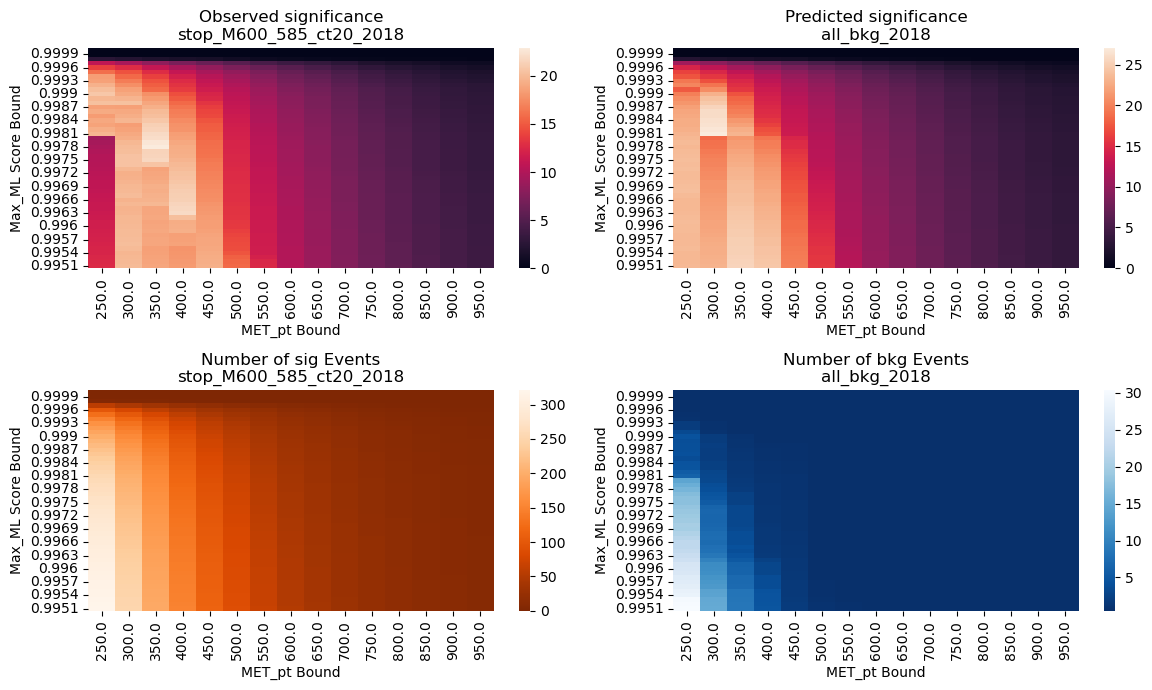

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
tag=sig_tag

ylabel = 'Max_ML Score Bound'
xlabel = 'MET_pt Bound'

plot_lowerBound = 0.995 # y_min

# Observed significance plot
sns.heatmap(store[tag + '_Z_NA'][plot_lowerBound:], ax=axs[0,0])
axs[0,0].set(xlabel=xlabel, ylabel=ylabel, title='Observed significance\n' + tag)
axs[0,0].set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), axs[0,0].get_yticklabels())])
axs[0,0].invert_yaxis()

# Predicted significance plot
sns.heatmap(store[tag + '_Z_NA_pred'][plot_lowerBound:], ax=axs[0,1])
axs[0,1].set(xlabel=xlabel, ylabel=ylabel, title='Predicted significance\n' + 'all_bkg_2018')
axs[0,1].set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), axs[0,1].get_yticklabels())])
axs[0,1].invert_yaxis()

# Signal plot
sns.heatmap(store[tag + '_sig_NA'][plot_lowerBound:], cmap='Oranges_r', ax=axs[1,0])
axs[1,0].set(xlabel=xlabel, ylabel=ylabel, title='Number of sig Events\n' + tag)
axs[1,0].set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), axs[1,0].get_yticklabels())])
axs[1,0].invert_yaxis()

# Background plot
sns.heatmap(store[tag + '_bkg_NA'][plot_lowerBound:], cmap='Blues_r', ax=axs[1,1])
axs[1,1].set(xlabel=xlabel, ylabel=ylabel, title='Number of bkg Events\n' + 'all_bkg_2018')
axs[1,1].set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), axs[1,1].get_yticklabels())])
axs[1,1].invert_yaxis()

fig.tight_layout()
fig.show()


In [ ]:
print(round(store[sig_tag + "_bkg_NB"].index[-1], 6))
print(round(store[sig_tag + "_bkg_NB"].columns[3], 0))

1.0
400.0


In [ ]:
store[sig_tag + '_Z_NA'].loc[0.999:, :450]

,250.0,300.0,350.0,400.0,450.0
0.9991,2.251967,2.248273,2.358847,2.584172,2.093402
0.9992,2.396072,2.377766,2.616129,2.468251,1.996291
0.9993,2.498369,2.496633,2.885505,2.827767,2.352038
0.9994,2.563554,2.564731,2.658907,2.631246,2.178834
0.9995,2.428701,2.923958,2.873030,2.385870,1.973153
0.9996,2.009180,2.455386,2.447137,2.025664,1.669822
0.9997,1.796135,2.066270,1.690499,1.368592,1.100158
0.9998,0.343160,0.262500,0.217354,0.160269,0.141193
0.9999,0.000000,0.000000,0.000000,0.000000,0.000000
1.0000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
store[sig_tag + '_Z_NA'].iloc[-2,3]

0.0

In [ ]:
# print(f'NA: {store[sig_tag + "_bkg_NA"].iloc[-8,3]} +/- {store[sig_tag + "_bkg_NA_unc"].iloc[-8,3]}')
print(f'NB: {store[sig_tag + "_bkg_NB"].iloc[-2,3]} +/- {store[sig_tag + "_bkg_NB_unc"].iloc[-2,3]}')
print(f'NC: {store[sig_tag + "_bkg_NC"].iloc[-2,3]} +/- {store[sig_tag + "_bkg_NC_unc"].iloc[-2,3]}')
print(f'ND: {store[sig_tag + "_bkg_ND"].iloc[-2,3]} +/- {store[sig_tag + "_bkg_ND_unc"].iloc[-2,3]}')


SPRB: 75.7265844695817 +/- 11.04753814938583
SPRC: 5645.954460377956 +/- 59.421774212011265
SPRD: 122403.78773063312 +/- 780.8326371959705


In [132]:
f_B = ufloat(64.95118090785805, 10.24168017233881) / ufloat(129.74137883499245, 18.46953400253708)
f_C = ufloat(4972.575722054323, 63.20730017273657) / ufloat(9642.685986809784, 100.02463163394061)
f_D = ufloat(95650.71685582052, 838.9132564909049) / ufloat(208527.3141139648, 1311.1127886045672)

print("f_B:", f_B)
print("f_C:", f_C)
print("f_D:", f_D)

f_B: 0.50+/-0.11
f_C: 0.516+/-0.008
f_D: 0.459+/-0.005


In [135]:
(f_C/f_D) * f_B * ufloat(129.74137883499245, 18.46953400253708)

73.02055892221767+/-18.728064863359897

In [ ]:
store[tag + '_sig_NB'].loc[0.999:, :450]

,250.0,300.0,350.0,400.0,450.0
0.9991,3.613198,7.012396,9.729498,11.870316,13.441857
0.9992,3.430240,6.647844,9.205820,11.239286,12.717320
0.9993,3.153858,6.106644,8.487057,10.344897,11.692171
0.9994,2.807500,5.466843,7.638892,9.292307,10.506040
0.9995,2.460162,4.685567,6.579326,7.992253,9.021895
0.9996,1.860485,3.607206,5.074650,6.163022,6.950905
0.9997,1.088727,2.047721,2.895871,3.543033,4.010537
0.9998,0.113476,0.199834,0.246228,0.306457,0.324906
0.9999,0.000000,0.000000,0.000000,0.000000,0.000000
1.0000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
store[tag + '_bkg_NA'].loc[0.999:, :450]

,250.0,300.0,350.0,400.0,450.0
0.9991,15.328985,10.383760,4.543043,2.194217,1.638586
0.9992,11.188561,7.580735,2.873501,1.691053,1.544584
0.9993,8.798071,5.377026,1.658631,0.500000,0.500000
0.9994,5.368376,3.704655,1.338651,0.500000,0.500000
0.9995,2.607061,1.562292,0.500000,0.500000,0.500000
0.9996,1.198395,1.055269,0.500000,0.500000,0.500000
0.9997,0.500000,0.500000,0.500000,0.500000,0.500000
0.9998,0.500000,0.500000,0.500000,0.500000,0.500000
0.9999,0.500000,0.500000,0.500000,0.500000,0.500000
1.0000,0.500000,0.500000,0.500000,0.500000,0.500000


In [ ]:
store[tag + '_sig_NA'].loc[0.998:]

In [ ]:
store[tag + '_bkg_NA'].loc[0.998:]

In [ ]:
store[tag + '_signifTable'].loc[0.995:, 200:500]

In [ ]:
print(store[tag + '_signifTable'].loc[0.999:, 200:500].to_markdown())

In [ ]:
iML  = -12
iMET = +4
sysUnc = 0.20

print(f"Regions for {sig_tag} (with {sysUnc*100:.0f}% bkg syst. unc.)")
print("Integrated luminosity = 100 fb-1")
print("Cross-section is scaled down to 6.83 fb")
print()
print(f"ML_cut:  {store[sig_tag + '_sig_NA_Table'].index[iML]:.5f}")
print(f"MET_cut: {store[sig_tag + '_sig_NA_Table'].columns[iMET]:.0f}")
print()

print("Signal")
print("."*40)
print("A: ", round(store[sig_tag + '_sig_NA_Table'].iloc[iML,iMET], 2))
print("B: ", round(store[sig_tag + '_sig_NB_Table'].iloc[iML,iMET], 2))
print("C: ", round(store[sig_tag + '_sig_NC_Table'].iloc[iML,iMET], 2))
print("D: ", round(store[sig_tag + '_sig_ND_Table'].iloc[iML,iMET], 2))
print()
print("Background")
print("."*40)
print("A: ", round(store[sig_tag + '_bkg_NA_Table'].iloc[iML,iMET], 2))
print("B: ", round(store[sig_tag + '_bkg_NB_Table'].iloc[iML,iMET], 2))
print("C: ", round(store[sig_tag + '_bkg_NC_Table'].iloc[iML,iMET], 2))
print("D: ", round(store[sig_tag + '_bkg_ND_Table'].iloc[iML,iMET], 2))
print()
print("ROOT RooStats AsimovSignificance")
print("."*40)
print("A: ", round(ROOT.RooStats.AsimovSignificance(store[sig_tag + '_sig_NA_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_NA_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_NA_Table'].iloc[iML,iMET] * sysUnc), 2))

print("B: ", round(ROOT.RooStats.AsimovSignificance(store[sig_tag + '_sig_NB_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_NB_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_NB_Table'].iloc[iML,iMET] * sysUnc), 2))

print("C: ", round(ROOT.RooStats.AsimovSignificance(store[sig_tag + '_sig_NC_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_NC_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_NC_Table'].iloc[iML,iMET] * sysUnc), 2))

print("D: ", round(ROOT.RooStats.AsimovSignificance(store[sig_tag + '_sig_ND_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_ND_Table'].iloc[iML,iMET],
                                                    store[sig_tag + '_bkg_ND_Table'].iloc[iML,iMET] * sysUnc), 2))



In [ ]:
store[tag + '_sigTable'].loc[0.9970:, 200:500]

In [ ]:
store[tag + '_bkgTable'].loc[0.9970:, 200:500]

In [ ]:
sig(146.269714, 0, 0)

In [ ]:
store[tag + '_bkgpredTable'].loc[3.5:4.0]

In [ ]:
store[tag + '_sigTable'].loc[0.998:0.999]

In [ ]:
store[tag + '_signifTable'].loc[3.5:4.0]

In [ ]:
store[tag + '_signifpredTable'].loc[3.5:4.0]

In [ ]:
store[tag + '_signifTable'].loc[0.998:0.999]

In [ ]:
tmp_df = store[tag + '_signifTable'].to_numpy()
tmp_df[np.isnan(tmp_df)] = 0.
np.where(tmp_df == tmp_df.max())
store[tag + '_signifTable'].iloc[50:150:10,5:6]

In [ ]:
store[tag + '_signifTable'].index[116]

In [ ]:
df = store[tag + '_signifpredTable']
df_values = df.values
np.max(df_values[~np.isnan(df_values)])

In [ ]:
from matplotlib.colors import LogNorm, Normalize

In [ ]:
s = sns.heatmap(store[tag + '_sigTable'], norm=LogNorm(), cmap='Oranges_r')
s.set(xlabel='MET_pt', ylabel='ML Score', title='Number of sig Events\n'+tag);
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();

In [ ]:
s = sns.heatmap(store[tag + '_bkgTable'], norm=LogNorm(), cmap='Blues_r')
s.set(xlabel='MET_pt', ylabel='ML Score', title='Number of bkg Events\n'+"all_bkg");
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();

In [ ]:
s = sns.heatmap(store[tag + '_signifTable'])
s.set(xlabel='MET_pt', ylabel='ParTScore', title='STOP Discovery Significances\n'+tag);
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();

In [ ]:
# store[tag + '_signifTable']

In [ ]:
df = store[tag + '_signifTable']
df_values = df.values
np.max(df_values[~np.isnan(df_values)])

In [ ]:
df[~df.isna()]

In [ ]:
store[tag + '_sigTable'][0.992:]

In [ ]:
store[tag + '_bkgTable'][0.992:]

In [ ]:
store[tag + '_bkgpredTable'][0.992:]

In [ ]:
store[tag + '_bkgpredTable'][0.992:] / store[tag + '_bkgTable'][0.992:]

In [ ]:
store[tag + '_bkgpredUncTable'][0.992:]

In [ ]:
store[tag + '_bkgUncTable'][0.992:]

In [ ]:
store[tag + '_bkgUncTable'].loc[0.998:,1000]

In [ ]:
store[tag + '_bkgTable'].loc[0.998:,1000]

In [ ]:
store[tag + '_bkgpredUncTable'].loc[0.998:,1000]

In [ ]:
store[tag + '_bkgpredTable'].loc[0.998:,1000]

In [ ]:
(store[tag + '_bkgpredTable'].loc[0.998:,1000]/ store[tag + '_bkgpredUncTable'].loc[0.998:,1000])**2

In [ ]:
(0.00782 / 0.002401)**2

In [ ]:
(0.056571 / 0.056571)**2

In [ ]:
ufloat(0.00782, 0.002401) / ufloat(0.056571, 0.056571)

In [ ]:
import ROOT

# --- 1. create one‑bin histograms with your Poisson counts ------------------
h_num = ROOT.TH1D("num","",1,0,1)   # numerator: n1
h_den = ROOT.TH1D("den","",1,0,1)   # denominator: n2
h_num.SetBinContent(1, 10)          # e.g. n1 = 10
h_den.SetBinContent(1, 1)          # e.g. n2 = 73   (change to your numbers)

# --- 2. build the ratio of Poisson means with 68.3 % (1 σ) Clopper‑Pearson --
g = ROOT.TGraphAsymmErrors()
g.Divide(h_num, h_den, "pois cp")   # add "v" for verbose output if you like

# --- 3. access the central value and asymmetric errors ----------------------
ratio      = g.GetY()[0]            # τ̂  = n1 / n2
err_low    = g.GetErrorYlow(0)      # downward error
err_high   = g.GetErrorYhigh(0)     # upward   error
print(f"τ = {ratio:.6f}  +{err_high:.6f}/-{err_low:.6f}")

# optional: draw the graph (as a single point)
# c = ROOT.TCanvas()
# g.SetMarkerStyle(20)
# g.Draw("AP")
# c.Update()


In [ ]:
g.Divide(h_num, h_den, "pois fc")                   # Feldman‑Cousins 68 % CL
g.Divide(h_num, h_den, "pois b(0.5,0.5) shortest")  # Bayesian Jeffreys prior

In [ ]:
from uncertainties import ufloat

def ratio_gauss(muA, sigA, muB, sigB):
    """
    Return R = A/B with its propagated 1‑sigma error,
    assuming A and B are independent Gaussians.
    """
    a = ufloat(muA, sigA)
    b = ufloat(muB, sigB)
    return a / b

# example -------------------------------------------------------------
ra = ratio_gauss(0.00782,   0.002401,
                 0.056571,  0.056571)
print(ra)        # ==> 0.138233±0.144602

In [ ]:
from scipy import stats
import numpy as np

my_dict = {}
my_val = 0.7

mu1s_68 = []
mu2s_68 = []

mu1s_95 = []
mu2s_95 = []

trial1s = np.random.uniform(0, 300, 10000)
trial2s = np.random.uniform(0, 300, 10000)

for mu1, mu2 in zip(trial1s, trial2s):
    rvs1 = stats.poisson.rvs(mu1, size=1000)
    rvs2 = stats.poisson.rvs(mu2, size=1000)
    rvs_ratio = rvs1 / rvs2
    ci68 = np.percentile(rvs_ratio, [16, 84])
    ci95 = np.percentile(rvs_ratio, [2.5, 97.5])
    # if np.isnan(ci68[0]) or np.isnan(ci68[1]):
    #     continue
    if ci68[0] <= my_val <= ci68[1]:
        # print(f"my_val is inside the range of x: {x[0]:.2f} <= {my_val:.2f} <= {x[1]:.2f}")
        mu1s_68.append(mu1)
        mu2s_68.append(mu2)
    if ci95[0] <= my_val <= ci95[1]:
        # print(f"my_val is inside the range of x: {x[0]:.2f} <= {my_val:.2f} <= {x[1]:.2f}")
        mu1s_95.append(mu1)
        mu2s_95.append(mu2)
        
        # my_dict[f'{mu1:.2f}_{mu2:.2f}'] = x

In [ ]:
rvs1 = stats.poisson.rvs(200, size=1000)
rvs2 = stats.poisson.rvs(300, size=1000)
rvs_ratio = rvs1 / rvs2
x = np.percentile(rvs_ratio, [16, 84])
x

In [ ]:
plt.plot(mu1s_68, mu2s_68, 'o', markersize=1, color="blue")
plt.plot(trial1s, trial2s, 'o', markersize=1, color="red", alpha=0.1)

In [ ]:
plt.plot(mu1s_95, mu2s_95, 'o', markersize=1, color="blue")
plt.plot(trial1s, trial2s, 'o', markersize=1, color="red", alpha=0.1)

In [ ]:
l = [0, 2]
my_val = np.nan

if l[0] > my_val or l[-1] < my_val :
    print("my_val is outside the range of l")


In [ ]:
rvs1 = stats.poisson.rvs(20, size=1000)
rvs2 = stats.poisson.rvs(10, size=1000)
rvs_ratio = rvs1 / rvs2
x = np.percentile(rvs_ratio, [16, 50, 84])
x

In [ ]:
store[tag + '_closureUncTable'][0.992:]

In [ ]:
store[tag + '_signifTable'][0.992:]

In [ ]:
s = sns.heatmap(store[tag + '_signifTable'][0.992:], annot=True)
s.set(xlabel='MET_pt', ylabel='ParTScore', title='STOP Discovery Significances\n'+tag);
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();
plt.

In [ ]:
# d.to_csv(sep = "|")
tableName = tag + '_bkgTable'
print(f"Printing {tableName} \n")
d = store[tableName]
s = d.to_markdown()
s = "| ParTScore/MET_pt" + s[6:]
print(s)

In [ ]:
for key in bkg_histDict.keys():
    print(key)

In [ ]:
c = ROOT.TCanvas("c1","myCanvas1",600,600)
h = bkg_histDict['zjetstonunuht2500_2018']
h.Draw("COLZ")
h.GetXaxis().SetRange(-1, 1000)
h.GetYaxis().SetRange(-1, 1000)
c.Draw()

In [ ]:
sig(15.903, 4.079, 0.4513)

In [ ]:
sig(5, 4.079, 0.4513)

In [ ]:
5 / 15.903

In [ ]:
store[tag + '_sigTable']

In [ ]:
tag = 'stop_1000_980_2'

s = sns.heatmap(store[tag + '_bkgTable'], cmap="Blues_r")
s.set(xlabel='MET_pt', ylabel='LxySig', title='STOP Events\n'+tag);
s.invert_yaxis();

In [ ]:
# d.to_csv(sep = "|")
tag = 'stop_1000_980_2'
d = store[tag + '_bkgTable']
s = d.to_markdown()
s = "| LxySig/MET_pt " + s[6:]

In [ ]:
print(f"{s}")

In [ ]:
# hist.GetYaxis().GetBinUpEdge(hist.GetYaxis().GetNbins())

In [ ]:
store['stop_1000_988_200_sigTable']

In [ ]:
store['stop_1000_988_200_bkgTable']

In [ ]:
store['stop_1000_988_200_signifTable']

In [ ]:
def sig(s,b,b_err):
  return np.sqrt(2*((s+b)*np.log(((s+b)*(b+b_err*b_err))/(b*b+(s+b)*b_err*b_err)) - 
                    (b*b/(b_err*b_err))*np.log(1+(b_err*b_err*s)/(b*(b+b_err*b_err)))))

In [ ]:
sig(0.2, 0.5, 1e-154)

In [ ]:
0.2 / np.sqrt(0.5)